In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=0.9)
np.random.seed(0)

### a)

In [2]:
# generate sample 
n = 500

bern = scipy.stats.bernoulli.rvs(p=0.3, size=n)
norm1 = scipy.stats.norm.rvs(loc=1, scale=1, size=n)
norm2 = scipy.stats.norm.rvs(loc=5, scale=2, size=n)

X = np.where(bern == 1, norm1, norm2)

theoretical_density = lambda x: 0.3 * scipy.stats.norm.pdf(x, loc=1, scale=1) + 0.7 * scipy.stats.norm.pdf(x, loc=5, scale=2)

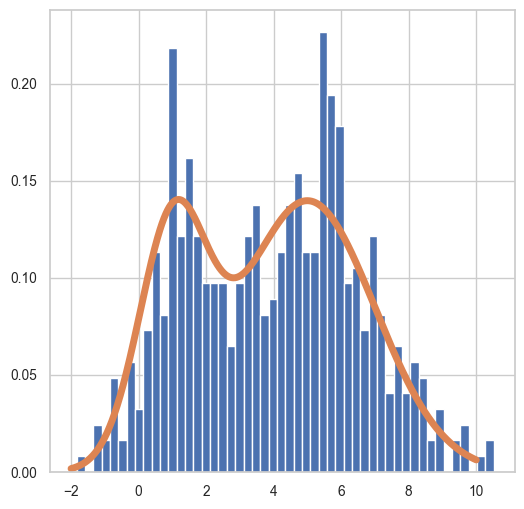

In [3]:
# histogram of a sample and true distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(X, bins=50, density=True)

X_plot = np.linspace(-2, 10, 1000)
true_dist = np.apply_along_axis(theoretical_density, axis=0, arr=X_plot)
ax.plot(X_plot, true_dist, lw=5)

plt.show()

### b)

In [4]:
def log_likelihood(x, mi0, mi1, sigma0, sigma1, pi, g):
    return np.sum( (1 - g) * (np.log(scipy.stats.norm.pdf(x, loc=mi0, scale=sigma0)) + np.log(1 - pi) ) 
               + g * (np.log(scipy.stats.norm.pdf(x, loc=mi1, scale=sigma1)) + np.log(pi) ) )

In [5]:
log_likelihood(X, 1, 5, 1, 2, 0.3, bern)

-4925.164131594424

### c)

In [6]:
# e-step
def e_step(x, mi0, mi1, sigma0, sigma1, pi):
    g = ( pi * scipy.stats.norm.pdf(x, loc=mi1, scale=sigma1) / 
        (pi * scipy.stats.norm.pdf(x, loc=mi1, scale=sigma1) + 
         (1 - pi) * scipy.stats.norm.pdf(x, loc=mi0, scale=sigma0))
    )
    return g

In [10]:
# accuracy
g = e_step(X, 1, 5, 1, 2, 0.3)
(1 - np.where(g > 0.5, 1, 0) == bern).mean()

0.898

### d)

In [13]:
# m-step
def m_step(x, g):
    pi = g.mean()
    mi0 = np.sum((1 - g) * x) / np.sum(1 - g)
    mi1 = np.sum(g * x) / np.sum(g)
    sigma0 = np.sqrt(np.sum((1 - g) * (x - mi0)**2) / np.sum(1 - g))
    sigma1 = np.sqrt(np.sum(g * (x - mi1)**2) / np.sum(g))
    return mi0, mi1, sigma0, sigma1, pi

### e)

In [14]:
# em-algorithm
def em_algorithm(x, mi0, mi1, sigma0, sigma1, pi, n_iter):    
    for _ in range(n_iter):
        g = e_step(x, mi0, mi1, sigma0, sigma1, pi)
        mi0, mi1, sigma0, sigma1, pi = m_step(x, g)
    return mi0, mi1, sigma0, sigma1, pi

In [39]:
# initial guess for em-algorithm
mi0 = 0
mi1 = 1
sigma0 = 1
sigma1 = 1
pi = 0.5
n_iter = 1000

mi0, mi1, sigma0, sigma1, pi = em_algorithm(X, mi0, mi1, sigma0, sigma1, pi, n_iter)
mi0, mi1, sigma0, sigma1, pi

(1.1241400904895005,
 5.272659695550879,
 1.0427929980399586,
 1.8708867539294622,
 0.688684746716965)

In [40]:
def estimated_density(x, mi0, mi1, sigma0, sigma1, pi):
    return (1 - pi) * scipy.stats.norm.pdf(x, loc=mi0, scale=sigma0) + pi * scipy.stats.norm.pdf(x, loc=mi1, scale=sigma1)

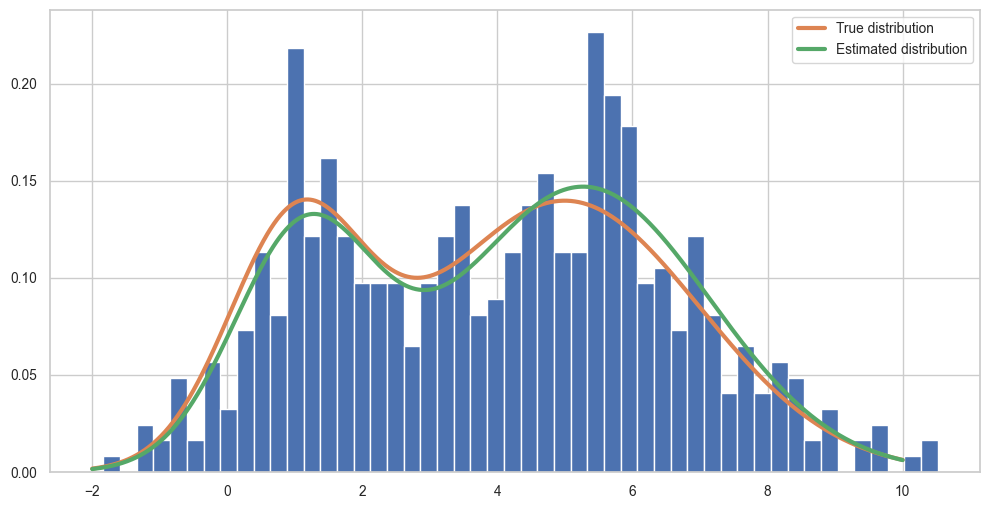

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(X, bins=50, density=True)

X_plot = np.linspace(-2, 10, 1000)
true_dist = np.apply_along_axis(theoretical_density, axis=0, arr=X_plot)
ax.plot(X_plot, true_dist, lw=3, label="True distribution")

X_plot = np.linspace(-2, 10, 1000)
estimated = np.apply_along_axis(lambda x: estimated_density(x, mi0, mi1, sigma0, sigma1, pi), axis=0, arr=X_plot)
ax.plot(X_plot, estimated, lw=3, label="Estimated distribution")

plt.legend()
plt.show()